<a href="https://colab.research.google.com/github/e-chong/Singapore-Ship-Detection/blob/master/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# install libraries

# suppress output
%%capture 

!pip install rasterio
!pip install geopandas
!pip install sentinelsat
!pip install satpy
!pip install glymur
!pip install python-geotiepoints
!pip install pyspectral
!pip install progressbar2
!pip install kaggle
!pip install tifffile

In [2]:
%tensorflow_version 1.x
%matplotlib inline

TensorFlow 1.x selected.


In [0]:
# Base dependencies
import numpy as np
import pandas as pd
import geopandas as gpd # vector spatial operations
import rasterio as rio # raster spatial operations
import json

# Plotting
from rasterio.plot import show #convenience wrapper for pyplot.imshow for RGB and 1 band images
import matplotlib.pyplot as plt

#Sentinel-2 I/O
from sentinelsat import SentinelAPI
from satpy.scene import Scene
from satpy import find_files_and_readers
import requests, zipfile, io, os, shutil # downloading and extracting zipfolders

# Sentinel-2 create patches
from shapely.geometry import Point # vector geometries
import time
import progressbar

# Resize Kaggle patches
from skimage.transform import resize
import tifffile as tiff
import scipy.ndimage

# SVM
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import svm
from sklearn.metrics import confusion_matrix, auc, roc_curve

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Functions
credit to # https://gis.stackexchange.com/questions/299787/finding-pixel-location-in-raster-using-coordinates

In [0]:
# Extracts RGB 3-channel image from SAFE directory and saves it in the working directory 
# and returns the path to the new file
def extract_rgb_jp2(safePath, sceneTitle):
  for subdirs, dirs, files in os.walk(safePath):
    for file in files:
      if file.endswith('_TCI.jp2'):
        rgbPath = os.path.join(subdirs, file)
        destPath = sceneTitle+'.jp2'
        print(f'Copying {file} to {destPath}')
        shutil.copy2(rgbPath, destPath)
        return destPath

In [0]:
# returns matrix of [n ships, patch_size, patch_size]
def create_ship_patches(ships, img, patch_size=50):
  coordinates = list(zip(ships.geometry.x, ships.geometry.y))
  with progressbar.ProgressBar(max_value=len(ships.index)) as bar: # creates progress bar
    patch_list = np.zeros([len(ships.index), patch_size, patch_size, len(img.indexes)])
    for i, (lon, lat) in enumerate(coordinates): # Loop through your list of coords
      py, px = img.index(lon, lat) # Get pixel coordinates from map coordinates
      window = rio.windows.Window(px - patch_size//2, py - patch_size//2, patch_size, patch_size) # Build an NxN window
      patch = img.read(window=window) # clip is a nbands * patch_size * patch_size numpy array
      patch_list[i] = np.transpose(patch, (1,2,0)) # transpose to [patch_size, patch_size, n bands]
      bar.update(i)
  return patch_list.astype(int)

In [0]:
# creates patches for use in classifying ship or no ship
def create_patches(img, patch_size=50, step_size=30):
  n_patches = len(range(0,img.height, step_size)) * len(range(0,img.width, step_size))
  patch_list = []
  index = 0
  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across image row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size)
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          pass
        else:
          # Read the data in the window
          patch = img.read(window=window) # patch is a nbands * patch_size * patch_size numpy array 
          patch_list.append(np.transpose(patch, (1,2,0))) # transpose to [patch_size, patch_size, n bands]
          index += 1
          bar.update(index)
  patch_array = np.stack(patch_list, axis=0)
  return patch_array.astype(int)

In [0]:
# returns boolean list of whether patches intersect with any ships
def patch_intersects_ship_buffers(ships, img, patch_size=50, step_size=30):
  n_patches = (len(range(0,img.height, step_size)) * len(range(0,img.width, step_size)))
  isShip_list = [] #list to hold all the patch locations
  buffer_list = []
  x_list = []
  y_list = []
  index = 0

  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across image row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size) #get patch window
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          pass #skip patches that extend off the edge so they have the wrong shape
        else:
          #create centroid point
          centroid = Point(img.transform *(window.col_off+patch_size/2, window.row_off+patch_size/2))
          buffer = centroid.buffer(img.transform[0]*step_size/1.5)
          buffer_list.append(buffer)
          isShip = np.any(ships.intersects(buffer)) #intersect ships with polygon and check if any are positive
          isShip_list.append(isShip) #append result to list
          x_list.append(x),
          y_list.append(y)
          index += 1
          bar.update(index)
  results = pd.DataFrame({'isShip':isShip_list, 'x':x_list, 'y':y_list, 'patch_size':patch_size})
  return results

In [0]:
# plots a patch
def plot_patch(img, x, y, patch_size=50, step_size=30):
  window = rio.windows.Window(x,y, patch_size, patch_size)
  patch = img.read(window=window)
  show(patch, title=f'x: {x}, y: {y}')

In [0]:
# creates patches for use in classifying ship or no ship
def predict_patch(model, img, x, y, patch_size=50):
  window = rio.windows.Window(x,y, patch_size, patch_size)
  patch = img.read(window=window)
  patch = np.transpose(patch, (1,2,0))
  patch = patch[np.newaxis, :]
  prediction = model.predict_classes(patch)
  return prediction

# Define Parameters

In [0]:
DRIVE_PATH = '/content/drive/My Drive/MUSA-650-Final-Project/'

In [0]:
#Load param file
with open(DRIVE_PATH+'params.json', 'r') as file:
    params = json.load(file)
    
    SENTINEL_USER = params['SENTINEL_USER']
    SENTINEL_PWD = params['SENTINEL_PWD']
    KAGGLE_USER = params['KAGGLE_USER']
    KAGGLE_KEY = params['KAGGLE_KEY']

In [0]:
# unique Sentinel-2 tile id for images covering Singapore
TILE_ID = "48NUG" 

In [0]:
# Patch parameters
PATCH_SIZE = 24
STEP_SIZE = 12
SCALE_FACTOR = 3.5/10 #PlanetScope GSD / Sentinel-2 GSD

# Download Data

## Kaggle PlanetScope

In [8]:
os.mkdir('.kaggle')
os.listdir()

['.config', 'drive', '.kaggle', 'sample_data']

In [0]:
token = {"username":KAGGLE_USER,"key":KAGGLE_KEY}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [10]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
- path is now set to: {/content}


In [11]:
!kaggle datasets download -d rhammell/ships-in-satellite-imagery -p /content

 91% 168M/185M [00:02<00:00, 63.5MB/s]
100% 185M/185M [00:02<00:00, 74.6MB/s]


In [12]:
os.listdir()

['.config',
 'drive',
 '.kaggle',
 'ships-in-satellite-imagery.zip',
 'sample_data']

In [0]:
with zipfile.ZipFile('ships-in-satellite-imagery.zip', 'r') as kaggleZip:
      kaggleZip.extractall(os.getcwd())

In [14]:
# with open('shipsnet.json') as data_file:
#     kg_ships_df = pd.DataFrame(json.load(data_file))
# print(kg_ships_df.shape)
# kg_ships_df.head()

(4000, 4)


,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [15]:
with open('shipsnet.json') as data_file:
    kg_ships_dict = json.load(data_file)

kg_ships_df = pd.DataFrame(kg_ships_dict)
kg_ships_df.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [18]:
n_spectrum = 3 # color channel (RGB)
kg_patch_size = 80
kg_ships_patches = np.array(kg_ships_dict['data']
             ).astype('uint8'
             ).reshape([-1, n_spectrum, kg_patch_size, kg_patch_size])
kg_ships_patches = np.moveaxis(kg_ships_patches, 1, 3)
kg_ships_patches.shape

(4000, 80, 80, 3)

In [19]:
kg_ships_patches.min(), kg_ships_patches.max()

(1, 255)

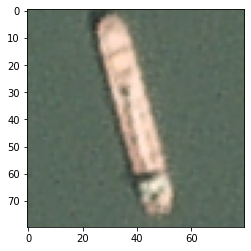

In [20]:
plt.imshow(kg_ships_patches[100])

In [25]:
kg_patch_new_size = round(kg_patch_size*SCALE_FACTOR)
print(kg_patch_new_size)
kg_patches_resize = np.zeros([kg_ships_patches.shape[0],
                            kg_patch_new_size,
                            kg_patch_new_size,
                            kg_ships_patches.shape[3]])

28


In [0]:
for img in range(kg_ships_patches.shape[0]):
  kg_patches_resize[img] = resize(kg_ships_patches[img], [kg_patch_new_size, kg_patch_new_size])

((4000, 28, 28, 3), <matplotlib.image.AxesImage at 0x7f4934321ac8>)

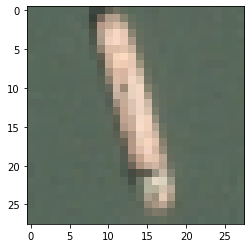

In [27]:
kg_patches_resize.shape, plt.imshow(kg_patches_resize[100])

In [29]:
kg_ships_df.labels[100]

1

# Train SVM

In [0]:
x_svm = kg_patches_resize.reshape([kg_patches_resize.shape[0],
                    kg_patches_resize.shape[1] *
                    kg_patches_resize.shape[2] *
                    kg_patches_resize.shape[3]])

y_svm = np.array(kg_ships_df.labels)

Split training/testing data

In [0]:
x_train_svm, x_test_svm, y_train_svm, y_test_svm = train_test_split(x_svm, 
                                                    y_svm, 
                                                    stratify = y_svm, 
                                                    train_size = 0.5, 
                                                    random_state=123)

In [53]:
type(x_svm), x_svm.shape, type(y_svm), y_svm.shape

(numpy.ndarray, (4000, 2352), numpy.ndarray, (4000,))

Train SVM with default parameters

In [70]:
# train SVM
svc = svm.SVC()
svc.fit(x_train_svm, y_train_svm)

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=1)

In [0]:
# Test fitted SVM
yPred_svm = svc.predict(x_test_svm)
yTrainPred_svm = svc.predict(x_train_svm)
yProb_svm = svc.decision_function(x_test_svm)
fpr, tpr, thresh = roc_curve(y_test_svm, yProb_svm)
aucVal = auc(fpr, tpr)

In [61]:
# Accuracy
print('Test Accuracy: ' + str(100 * np.sum(yPred_svm==y_test_svm) / y_test_svm.shape[0]))
print('Train Accuracy: ' + str(100 * np.sum(yTrainPred_svm==y_train_svm) / y_train_svm.shape[0]))
print('AUC: ' + str(aucVal))

Test Accuracy: 95.9
Train Accuracy: 98.0
AUC: 0.9906053333333333


Optimize parameters

In [0]:
x_train_svm, x_test_svm, y_train_svm, y_test_svm = train_test_split(x_svm, 
                                                    y_svm, 
                                                    stratify = y_svm, 
                                                    train_size = 0.8, 
                                                    random_state=123)

In [78]:
# Optimize hyperparameters for 
svc = svm.SVC(verbose=1)

param_grid = {'kernel':('linear', 'sigmoid', 'rbf'), 
              'C': [1, 10, 100], 
              'gamma': ('scale', 'auto')}

search = GridSearchCV(svc, param_grid, 
                      verbose = 10,
                      n_jobs = -1,
                      cv = 10).fit(x_train_svm, y_train_svm)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 14

[LibSVM]

In [83]:
clf = search.best_estimator_
clf

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=1)

In [85]:
# Outer 10-fold CV
nested_score = cross_val_score(clf, X=x_test_svm, y=y_test_svm, cv=10)
mean_accuracy = nested_score.mean()

print("Mean Accuracy (10-fold CV): " + str(mean_accuracy))
print("Maximum Fold Accuracy: " + str(nested_score.max()))
print("Minimum Fold Accuracy: " + str(nested_score.min()))

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Mean Accuracy (10-fold CV): 0.9512500000000002
Maximum Fold Accuracy: 0.975
Minimum Fold Accuracy: 0.9125
